In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.formula.api import ols

In [2]:
#한글설정
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

# Basic Statistics for 4 variables

In [5]:
df = pd.read_csv("all_data.csv",encoding='cp949')

In [7]:
df.describe()

,cpi,job,marry,birth
count,276.000000,276.000000,276.000000,276.000000
mean,86.308322,50.996739,5.893478,8.663043
std,12.897421,1.872681,1.424345,2.199936
min,62.393000,46.500000,3.300000,3.900000
25%,74.747750,49.700000,4.900000,7.200000
50%,89.886000,50.900000,5.900000,9.000000
75%,97.385000,52.500000,6.600000,9.900000
max,109.280000,55.600000,11.100000,15.400000


In [11]:
df1 = df.drop(columns='시점')
from scipy.stats import skew, kurtosis
skew(df1)

array([-0.270706  ,  0.13562897,  0.51856417,  0.07402999])

In [12]:
kurtosis(df1)

array([-1.16838719, -0.45603461,  0.54090348,  0.10952639])

# Standard Scaler

In [14]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df1)

In [53]:
df_s=pd.DataFrame(df_std, columns = ['cpi','job','marry','birth'])

In [57]:
df_s['time']=df.시점
df_s=df_s[['time','birth','marry','job','cpi']]
df_s['time'] = pd.to_datetime(df_s["time"])
df_s.head()

,time,birth,marry,job,cpi
0,2000-01-01,3.067904,1.129951,-2.405592,-1.852746
1,2000-02-01,2.931289,0.778275,-2.245103,-1.837910
2,2000-03-01,2.840212,1.200287,-1.710140,-1.813442
3,2000-04-01,2.248213,0.918946,-1.175176,-1.833094
4,2000-05-01,1.974982,2.044310,-0.747205,-1.857640


# Birth, Marry rate, Woman's Job, CPI Plot

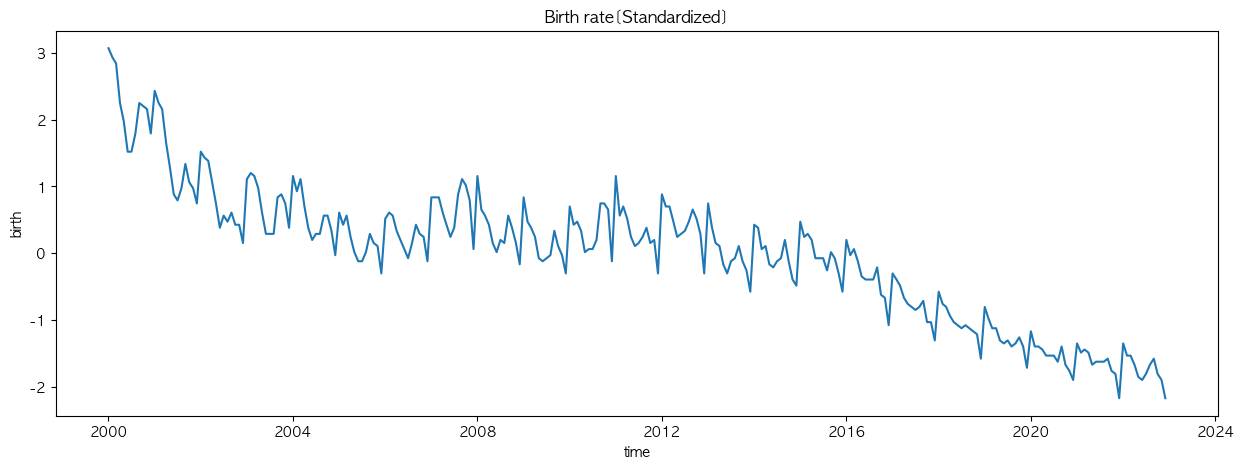

In [63]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df_s,x='time',y='birth')
plt.title('Birth rate[Standardized]')
plt.show()

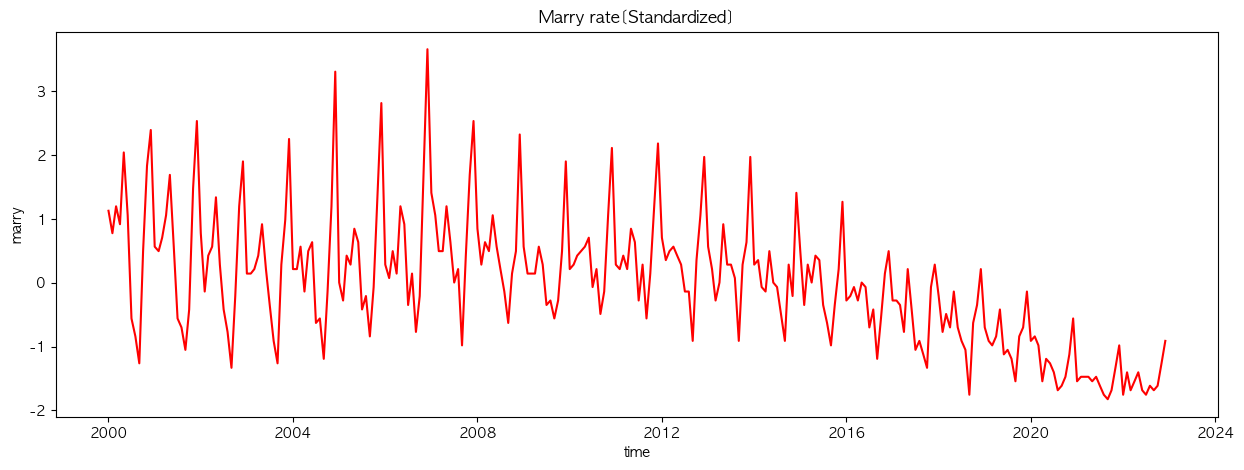

In [70]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df_s,x='time',y='marry',color='red')
plt.title('Marry rate[Standardized]')
plt.show()

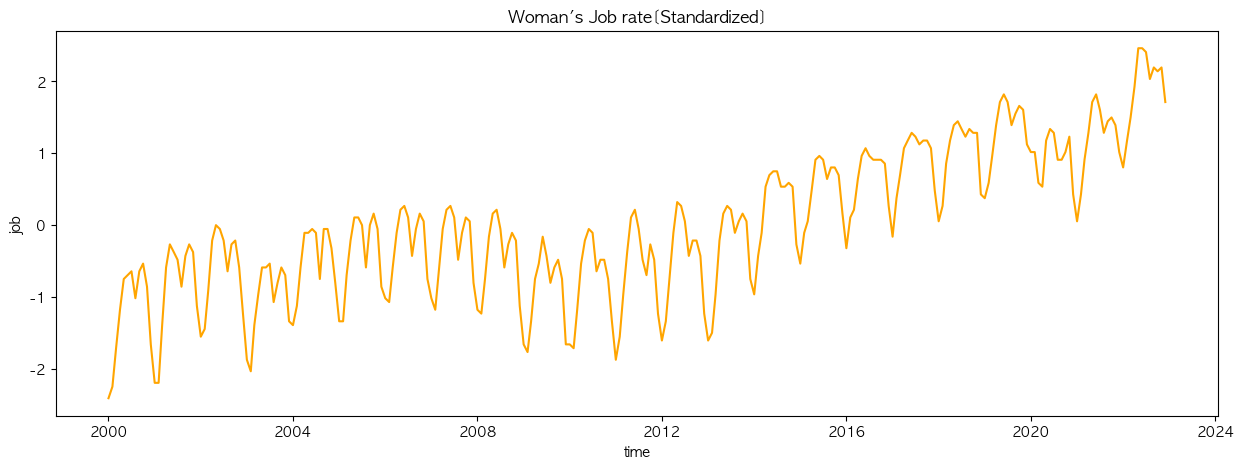

In [71]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df_s,x='time',y='job',color='orange')
plt.title('Woman\'s Job rate[Standardized]')
plt.show()

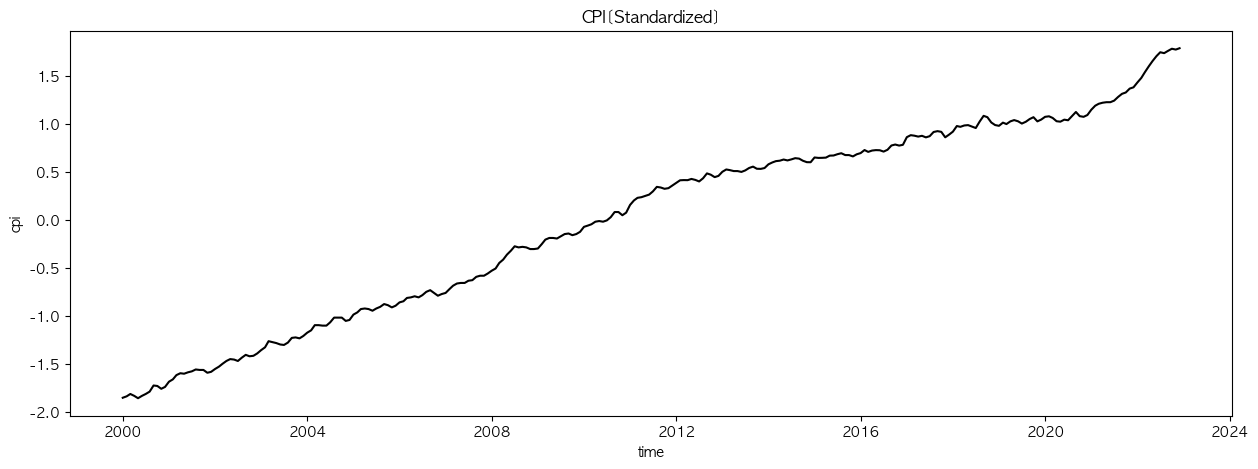

In [119]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df_s,x='time',y='cpi',color='Black')
plt.title('CPI[Standardized]')
plt.show()

In [103]:
def maa(data):
    L=[]
    for i in range(12,len(data)+1):
        L.append(data[i-12:i].mean())
    return L

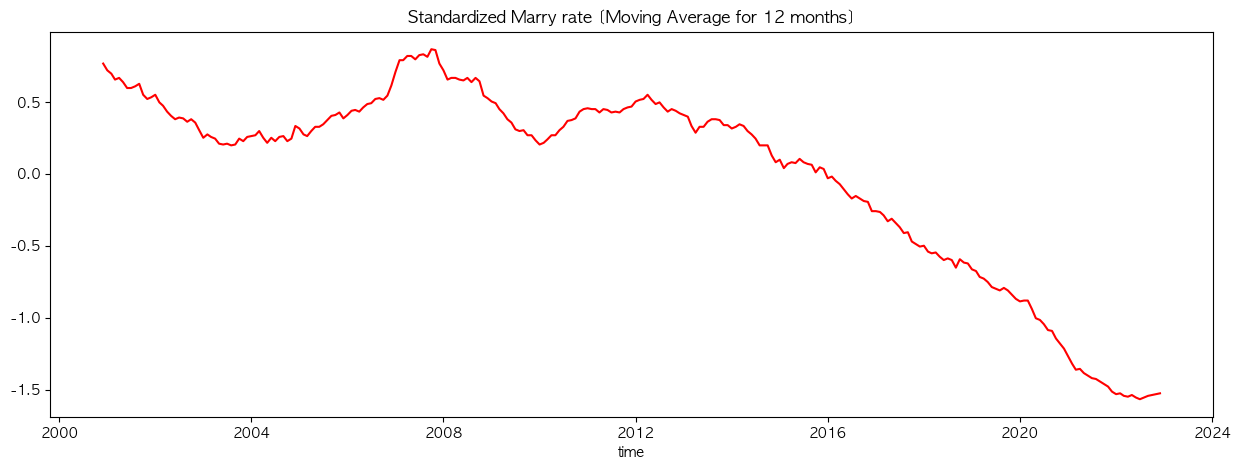

In [113]:
marry_ma = maa(df_s.marry)
tt=df_s.time[11:]
plt.figure(figsize=(15,5))
sns.lineplot(x=tt,y=marry_ma,color='red')
plt.title('Standardized Marry rate [Moving Average for 12 months]')
plt.show()

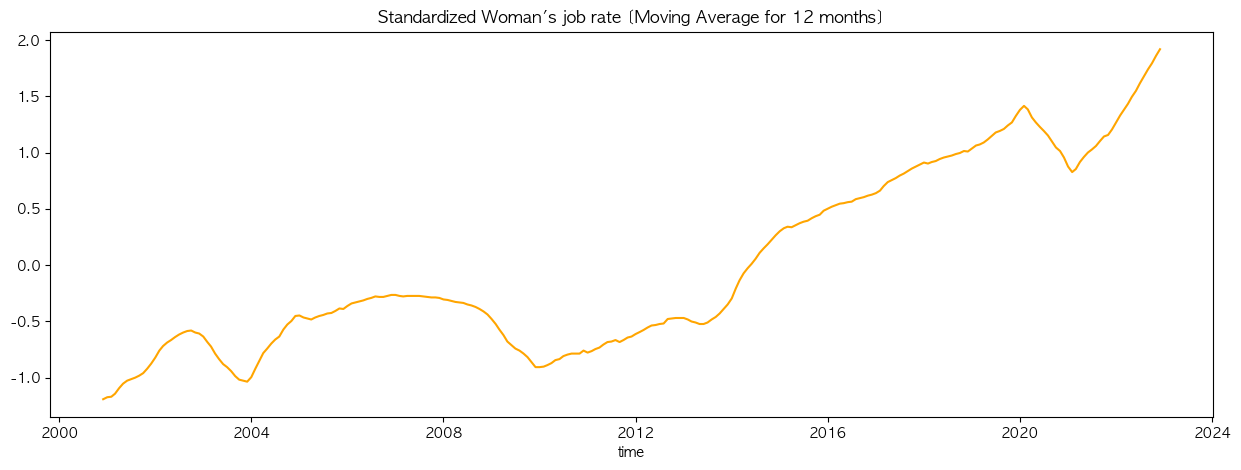

In [111]:
job_ma = maa(df_s.job)
tt=df_s.time[11:]
plt.figure(figsize=(15,5))
sns.lineplot(x=tt,y=job_ma,color='orange')
plt.title('Standardized Woman\'s job rate [Moving Average for 12 months]')
plt.show()

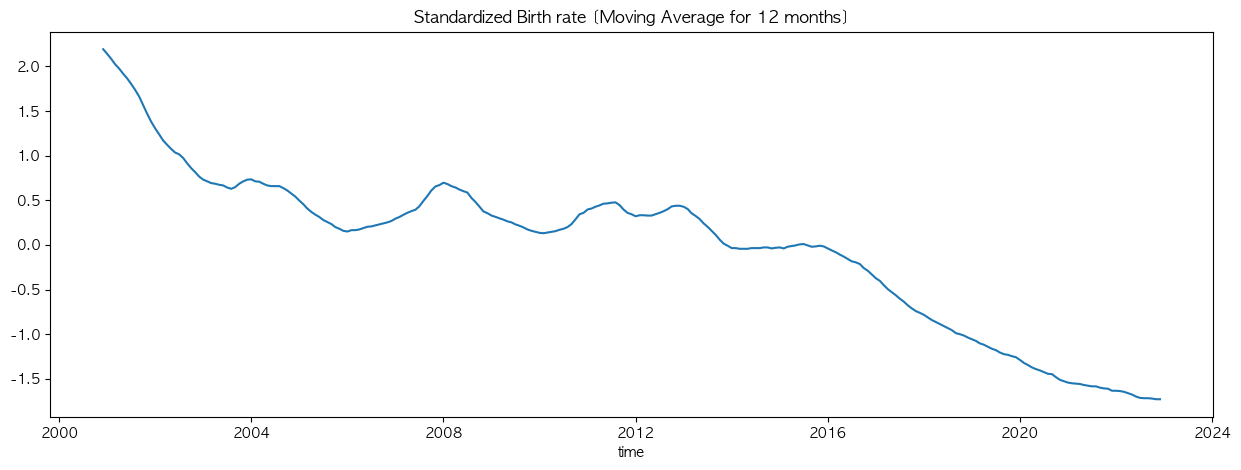

In [117]:
birth_ma = maa(df_s.birth)
tt=df_s.time[11:]
plt.figure(figsize=(15,5))
sns.lineplot(x=tt,y=birth_ma)
plt.title('Standardized Birth rate [Moving Average for 12 months]')
plt.show()

# VAR basic 1

## Marry model

In [120]:
Mt = pd.read_csv('m_ts.csv')
Bt = pd.read_csv('b_ts.csv')

In [126]:
mt_model = ols(formula = 'm_t ~ m_t_1 + b_t_1 + cpi + job -1',data = Mt).fit()
print(mt_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    m_t   R-squared (uncentered):                   0.505
Model:                            OLS   Adj. R-squared (uncentered):              0.498
Method:                 Least Squares   F-statistic:                              69.07
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                    3.02e-40
Time:                        17:43:58   Log-Likelihood:                         -293.42
No. Observations:                 275   AIC:                                      594.8
Df Residuals:                     271   BIC:                                      609.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [127]:
eps=[]
for i in range(len(Mt)):
    e=Mt.m_t[i] - 0.4703 * Mt.m_t_1[i] + 0.1502 * Mt.b_t_1[i] + 0.2376 * Mt.cpi[i] + 0.2354 * Mt.job[i]
    eps.append(e)
Mt['eps'] = pd.Series(eps)

In [128]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
Mt.set_index(df.index[1:],inplace=True)
ma_model_1 = SARIMAX(Mt.eps.values, order=(0,0,1),trend=None)
mt_model_fit = ma_model_1.fit()
mt_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05009D+00    |proj g|=  3.73926D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   7.062D-06   1.049D+00
  F =   1.0492603060945238     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  275
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -288.547
Date:                Wed, 26 Apr 2023   AIC                            581.093
Time:                        17:51:21   BIC                            588.327
Sample:                             0   HQIC                           583.996
                                - 275                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2000      0.048      4.177      0.000       0.106       0.294
sigma2         0.4773      0.037     12.792      0.000       0.404       0.550
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.28
Prob(Q):                              0.88   Prob(JB):                         0.19
Heteroskedasticity (H):               0.27   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Birth model

In [131]:
bt_model = ols(formula = 'b_t ~ m_t_1 + b_t_1 + cpi + job -1',data = Bt).fit()
print(bt_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    b_t   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                              791.7
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                   3.97e-148
Time:                        18:02:09   Log-Likelihood:                         -36.616
No. Observations:                 275   AIC:                                      81.23
Df Residuals:                     271   BIC:                                      95.70
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [132]:
eps1=[]
for i in range(len(Bt)):
    e=Bt.b_t[i] - 0.0869 * Bt.m_t_1[i] - 0.6921 * Bt.b_t_1[i] + 0.0931 * Bt.cpi[i] + 0.1554 * Bt.job[i]
    eps1.append(e)
Bt['eps'] = pd.Series(eps1)

In [134]:
Bt.set_index(df.index[1:],inplace=True)
ma_model_1 = SARIMAX(Bt.eps.values, order=(0,0,1),trend=None)
mt_model_fit = ma_model_1.fit()
mt_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20092D-01    |proj g|=  4.49608D-02

At iterate    5    f=  1.20054D-01    |proj g|=  1.64189D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.642D-07   1.201D-01
  F =  0.12005372797720763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  275
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -33.015
Date:                Wed, 26 Apr 2023   AIC                             70.030
Time:                        18:09:40   BIC                             77.263
Sample:                             0   HQIC                            72.933
                                - 275                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1478      0.046     -3.182      0.001      -0.239      -0.057
sigma2         0.0744      0.005     13.723      0.000       0.064       0.085
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 6.26
Prob(Q):                              0.73   Prob(JB):                         0.04
Heteroskedasticity (H):               0.49   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# VAR per 12 month

In [138]:
df_12=pd.DataFrame(columns=['time','birth','marry','cpi','job'])
df_12['time']=df_s.time[11:]
df_12['birth']=birth_ma
df_12['marry']=marry_ma
df_12['job']=job_ma
df_12['cpi']=df_s.cpi[11:]

In [139]:
df_12

,time,birth,marry,cpi,job
11,2000-12-01,2.191290,0.766552,-1.739961,-1.193008
12,2001-01-01,2.138161,0.719662,-1.685899,-1.175176
13,2001-02-01,2.081238,0.696217,-1.661431,-1.170718
14,2001-03-01,2.024315,0.655188,-1.617234,-1.143970
15,2001-04-01,1.974982,0.666911,-1.597659,-1.094931
...,...,...,...,...,...
271,2022-08-01,-1.717426,-1.554511,1.733076,1.677964
272,2022-09-01,-1.717426,-1.542789,1.757155,1.740377
273,2022-10-01,-1.721221,-1.536928,1.778904,1.793873
274,2022-11-01,-1.728810,-1.531066,1.770360,1.860743


In [140]:
df_12.to_csv('df_12.csv',index=False)

In [142]:
Bt = pd.read_csv('b_t12.csv')
Mt = pd.read_csv('m_t12.csv')

## Marry model

In [143]:
mt_model = ols(formula = 'm_t ~ m_t_1 + b_t_1 + cpi + job -1',data = Mt).fit()
print(mt_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    m_t   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          3.154e+04
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                        0.00
Time:                        18:32:55   Log-Likelihood:                          552.77
No. Observations:                 264   AIC:                                     -1098.
Df Residuals:                     260   BIC:                                     -1083.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [145]:
eps=[]
for i in range(len(Mt)):
    e=Mt.m_t[i] - 1.0122 * Mt.m_t_1[i] + 0.0245 * Mt.b_t_1[i] + 0.0107 * Mt.cpi[i] + 0.0115 * Mt.job[i]
    eps.append(e)
Mt['eps'] = pd.Series(eps)
from statsmodels.tsa.statespace.sarimax import SARIMAX
ma_model_1 = SARIMAX(Mt.eps.values, order=(0,0,1),trend=None)
mt_model_fit = ma_model_1.fit()
mt_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.11736D+00    |proj g|=  5.12044D-01

At iterate    5    f= -2.11759D+00    |proj g|=  4.53996D-01

At iterate   10    f= -2.11769D+00    |proj g|=  1.89045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     28      1     0     0   1.890D-04  -2.118D+00
  F =  -2.1176902207063861     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 559.070
Date:                Wed, 26 Apr 2023   AIC                          -1114.140
Time:                        18:44:00   BIC                          -1106.989
Sample:                             0   HQIC                         -1111.267
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2144      0.059      3.663      0.000       0.100       0.329
sigma2         0.0008   7.09e-05     11.942      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.41   Prob(JB):                         0.62
Heteroskedasticity (H):               0.69   Skew:                             0.01
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Birth model

In [146]:
bt_model = ols(formula = 'b_t ~ m_t_1 + b_t_1 + cpi + job -1',data = Bt).fit()
print(bt_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    b_t   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.875e+04
Date:                Wed, 26 Apr 2023   Prob (F-statistic):                        0.00
Time:                        18:46:30   Log-Likelihood:                          583.32
No. Observations:                 264   AIC:                                     -1159.
Df Residuals:                     260   BIC:                                     -1144.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [147]:
eps1=[]
for i in range(len(Bt)):
    e=Bt.b_t[i] - 0.0387 * Bt.m_t_1[i] - 0.9472 * Bt.b_t_1[i] + 0.0077 * Bt.cpi[i] + 0.0166 * Bt.job[i]
    eps1.append(e)
Bt['eps'] = pd.Series(eps1)
ma_model_1 = SARIMAX(Bt.eps.values, order=(0,0,1),trend=None)
mt_model_fit = ma_model_1.fit()
mt_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.50949D+00    |proj g|=  1.93462D+01

At iterate    5    f= -2.59823D+00    |proj g|=  6.44157D-02

At iterate   10    f= -2.59836D+00    |proj g|=  1.24996D+00

At iterate   15    f= -2.60056D+00    |proj g|=  4.49621D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     40      1     0     0   3.950D-04  -2.601D+00
  F =  -2.6005848743772848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 686.554
Date:                Wed, 26 Apr 2023   AIC                          -1369.109
Time:                        18:50:40   BIC                          -1361.957
Sample:                             0   HQIC                         -1366.235
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7447      0.041     18.124      0.000       0.664       0.825
sigma2         0.0003   2.93e-05     10.978      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  15.95   Jarque-Bera (JB):                 3.43
Prob(Q):                              0.00   Prob(JB):                         0.18
Heteroskedasticity (H):               0.67   Skew:                             0.20
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""